In [2]:
from numpy import loadtxt
import pandas as pd
import matplotlib.pyplot as plt

# Data Load

In [59]:
# load dataset

X_train = loadtxt('C:/Users/user/Jupyter Notebook Project/Tugas Akhir/X_train.csv', delimiter=',')
y_train = loadtxt('C:/Users/user/Jupyter Notebook Project/Tugas Akhir/y_train.csv', delimiter=',')

# X_val = loadtxt('C:/Users/user/Jupyter Notebook Project/Tugas Akhir/X_val.csv', delimiter=',')
# y_val = loadtxt('C:/Users/user/Jupyter Notebook Project/Tugas Akhir/y_val.csv', delimiter=',')

# X_test = loadtxt('C:/Users/user/Jupyter Notebook Project/Tugas Akhir/X_test.csv', delimiter=',')
# y_test = loadtxt('C:/Users/user/Jupyter Notebook Project/Tugas Akhir/y_test.csv', delimiter=',')

In [60]:
X_train.shape

(148, 2)

In [61]:
y_train.shape

(148,)

# Create Quantum Model

In [47]:
# This cell is added by sphinx-gallery
# It can be customized to whatever you like
%matplotlib inline

import pennylane as qml
from pennylane import numpy as np
from pennylane.optimize import NesterovMomentumOptimizer

## Choose a Quantum Device

In [48]:
dev = qml.device("default.qubit", wires=2)

## Loss and Acc Metric

In [49]:
# MSE
def square_loss(labels, predictions):
    loss = 0
    for l, p in zip(labels, predictions):
        loss = loss + (l - p) ** 2

    loss = loss / len(labels)
    return loss

# true predictions/total predictions
def accuracy(labels, predictions):
    acc = 0
    for l, p in zip(labels, predictions):
        if abs(l - p) < 1e-5:
            acc = acc + 1
    acc = acc / len(labels)

    return acc

## Quantum Amplitude Encoding Function

In [50]:
def get_angles(x):

    beta0 = 2 * np.arcsin(np.sqrt(x[1] ** 2) / np.sqrt(x[0] ** 2 + x[1] ** 2 + 1e-12))
    beta1 = 2 * np.arcsin(np.sqrt(x[3] ** 2) / np.sqrt(x[2] ** 2 + x[3] ** 2 + 1e-12))
    beta2 = 2 * np.arcsin(np.sqrt(x[2] ** 2 + x[3] ** 2) / np.sqrt(x[0] ** 2 + x[1] ** 2 + x[2] ** 2 + x[3] ** 2))

    return np.array([beta2, -beta1 / 2, beta1 / 2, -beta0 / 2, beta0 / 2])


def statepreparation(a):
    qml.RY(a[0], wires=0)

    qml.CNOT(wires=[0, 1])
    qml.RY(a[1], wires=1)
    qml.CNOT(wires=[0, 1])
    qml.RY(a[2], wires=1)

    qml.PauliX(wires=0)
    qml.CNOT(wires=[0, 1])
    qml.RY(a[3], wires=1)
    qml.CNOT(wires=[0, 1])
    qml.RY(a[4], wires=1)
    qml.PauliX(wires=0)

In [51]:
x = np.array([0.53896774, 0.79503606, 0.27826503, 0.0])
ang = get_angles(x)


@qml.qnode(dev)
def test(angles=None):

    statepreparation(angles)

    return qml.expval(qml.PauliZ(0))


test(angles=ang)

print("x               : ", x)
print("angles          : ", ang)
print("amplitude vector: ", np.real(dev._state))

x               :  [0.54 0.8  0.28 0.  ]
angles          :  [ 0.56 -0.    0.   -0.98  0.98]
amplitude vector:  [ 5.39e-01  7.95e-01  2.78e-01 -2.20e-17]


## Define the Layer

In [52]:
def layer(W):
    qml.Rot(W[0, 0], W[0, 1], W[0, 2], wires=0)
    qml.Rot(W[1, 0], W[1, 1], W[1, 2], wires=1)
    qml.CNOT(wires=[0, 1])

## Build the Quantum Circuit, Define Cost Function, Create QVC

In [53]:
@qml.qnode(dev)
def circuit(weights, angles=None):
    statepreparation(angles)

    for W in weights:
        layer(W)

    return qml.expval(qml.PauliZ(0))


def variational_classifier(var, angles=None):
    weights = var[0]
    bias = var[1]
    return circuit(weights, angles=angles) + bias


def cost(weights, features, labels):
    predictions = [variational_classifier(weights, angles=f) for f in features]
    return square_loss(labels, predictions)

# Data Prep

## Data Padding, Normalization and Data Encoding

In [54]:
print("First X train sample (original)  :", X_train[0])

# pad the vectors to size 2^2 with constant values
padding = 0.3 * np.ones((len(X_train), 1))
X_pad = np.c_[np.c_[X_train, padding], np.zeros((len(X_train), 1))]
print("First X sample (padded)    :", X_pad[0])

# normalize each input
normalization = np.sqrt(np.sum(X_pad ** 2, -1))
X_train_norm = (X_pad.T / normalization).T
print("First X train sample (normalized):", X_train_norm[0])

# angles for state preparation are new features
features = np.array([get_angles(x) for x in X_train_norm])
print("First features sample      :", features[0])

# make the label binary becomes -1 or 1 instead of 0 or 1
Y = y_train*2 - 1

First X train sample (original)  : [8.72 7.92]
First X sample (padded)    : [8.72 7.92 0.3  0.  ]
First X train sample (normalized): [0.74 0.67 0.03 0.  ]
First features sample      : [ 0.05 -0.    0.   -0.74  0.74]


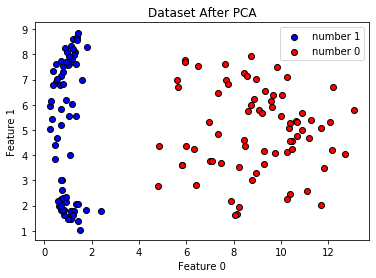

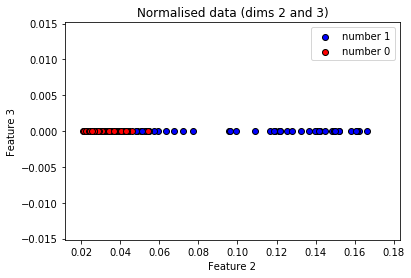

In [58]:
dim1 = 0
dim2 = 1

plt.figure()
plt.scatter(X_train[:, dim1][Y == 1], X_train[:, dim2][Y == 1], c="b", marker="o", edgecolors="k", label='number 1')
plt.scatter(X_train[:, dim1][Y == -1], X_train[:, dim2][Y == -1], c="r", marker="o", edgecolors="k", label='number 0')
plt.title("Dataset After PCA")
plt.ylabel('Feature ' + str(dim2))
plt.xlabel('Feature ' + str(dim1))
plt.legend()
plt.show()

dim1 = 2
dim2 = 3

plt.figure()
plt.scatter(X_train_norm[:, dim1][Y == 1], X_train_norm[:, dim2][Y == 1], c="b", marker="o", edgecolors="k", label='number 1')
plt.scatter(X_train_norm[:, dim1][Y == -1], X_train_norm[:, dim2][Y == -1], c="r", marker="o", edgecolors="k", label='number 0')
plt.title("Normalised data (dims {} and {})".format(dim1, dim2))
plt.ylabel('Feature ' + str(dim2))
plt.xlabel('Feature ' + str(dim1))
plt.legend()
plt.show()

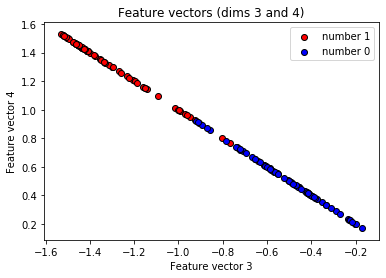

In [15]:
dim1 = 3
dim2 = 4

plt.figure()
plt.scatter(features[:, dim1][Y == 1], features[:, dim2][Y == 1], c="r", marker="o", edgecolors="k", label='number 1')
plt.scatter(features[:, dim1][Y == -1], features[:, dim2][Y == -1], c="b", marker="o", edgecolors="k", label='number 0')
plt.title("Feature vectors (dims {} and {})".format(dim1, dim2))
plt.ylabel('Feature vector ' + str(dim2))
plt.xlabel('Feature vector ' + str(dim1))
plt.legend()
plt.show()

In [16]:
pd.DataFrame(features)

,0,1,2,3,4
0,0.050925,-0.0,0.0,-0.737214,0.737214
1,0.052637,-0.0,0.0,-0.614070,0.614070
2,0.052505,-0.0,0.0,-0.409853,0.409853
3,0.050341,-0.0,0.0,-0.465641,0.465641
4,0.078827,-0.0,0.0,-0.590111,0.590111
...,...,...,...,...,...
143,0.154499,-0.0,0.0,-1.446895,1.446895
144,0.077295,-0.0,0.0,-1.454200,1.454200
145,0.102151,-0.0,0.0,-1.451151,1.451151
146,0.081811,-0.0,0.0,-1.462548,1.462548


## Train dan Val Dataset Separation

In [17]:
# separate train dataset into train and val dataset

np.random.seed(0)
num_data = len(Y)
num_train = int(0.75 * num_data)  # train = floor(75% train), val = ceil(25% train)
index = np.random.permutation(range(num_data))
feats_train = features[index[:num_train]]
Y_train = Y[index[:num_train]]
feats_val = features[index[num_train:]]
Y_val = Y[index[num_train:]]

# We need these later for plotting
X_val = X_train[index[num_train:]]
X_train = X_train[index[:num_train]]

In [18]:
feats_train.shape

(111, 5)

In [19]:
feats_val.shape

(37, 5)

# Training

## Qubits, Layers and Weights Initialization

In [20]:
# First we initialize the variables.

num_qubits = 2  # 2 label = 2 class = 2 quibits
num_layers = 6  # QNN layer
var_init = (0.01 * np.random.randn(num_layers, num_qubits, 3), 0.0)  # weights and bias initialization

## Training Iteration

In [21]:
# training

# array to save the training & val accuracy and loss history as the training goes
train_history = np.array([])
val_history = np.array([])
train_loss_history = np.array([])
val_loss_history = np.array([])
iter_history = np.array([])


# Again we optimize the cost. This may take a little patience.

opt = NesterovMomentumOptimizer(0.01)
batch_size = 5
max_iter = 100

# train the variational classifier
var = var_init
for it in range(max_iter):

    # Update the weights by one optimizer step
    batch_index = np.random.randint(0, num_train, (batch_size,))
    feats_train_batch = feats_train[batch_index]
    Y_train_batch = Y_train[batch_index]
    var = opt.step(lambda v: cost(v, feats_train_batch, Y_train_batch), var)

    # Compute predictions on train and validation set
    predictions_train = [np.sign(variational_classifier(var, angles=f)) for f in feats_train]
    predictions_val = [np.sign(variational_classifier(var, angles=f)) for f in feats_val]

    # Compute accuracy on train and validation set
    acc_train = accuracy(Y_train, predictions_train)
    acc_val = accuracy(Y_val, predictions_val)

    train_loss = cost(var, feats_train, Y_train)
    val_loss = cost(var, feats_val, Y_val)
    
    print(
        "Iter: {:5d} | Train Loss: {:0.7f} | Validation Loss: {:0.7f} | Train Acc: {:0.7f} | Validation Acc: {:0.7f} "
        "".format(it + 1, train_loss, val_loss, acc_train, acc_val)
    )
    
    iter_history = np.append(iter_history, it+1)
    train_loss_history = np.append(train_loss_history, train_loss)
    val_loss_history = np.append(val_loss_history, val_loss)
    train_history = np.append(train_history, acc_train)
    val_history = np.append(val_history, acc_val)
    
print("The training session is finished")

Iter:     1 | Train Loss: 1.9879832 | Validation Loss: 1.7797736 | Train Acc: 0.4864865 | Validation Acc: 0.5405405 
Iter:     2 | Train Loss: 1.9037684 | Validation Loss: 1.7054192 | Train Acc: 0.4864865 | Validation Acc: 0.5405405 
Iter:     3 | Train Loss: 1.8063903 | Validation Loss: 1.6200767 | Train Acc: 0.4864865 | Validation Acc: 0.5405405 
Iter:     4 | Train Loss: 1.6887989 | Validation Loss: 1.5181374 | Train Acc: 0.4864865 | Validation Acc: 0.5405405 
Iter:     5 | Train Loss: 1.5500052 | Validation Loss: 1.3998131 | Train Acc: 0.4864865 | Validation Acc: 0.5405405 
Iter:     6 | Train Loss: 1.4267417 | Validation Loss: 1.2972309 | Train Acc: 0.4864865 | Validation Acc: 0.5405405 
Iter:     7 | Train Loss: 1.3118602 | Validation Loss: 1.2048549 | Train Acc: 0.4864865 | Validation Acc: 0.5405405 
Iter:     8 | Train Loss: 1.2275746 | Validation Loss: 1.1400964 | Train Acc: 0.4864865 | Validation Acc: 0.5405405 
Iter:     9 | Train Loss: 1.1606424 | Validation Loss: 1.0918342

Iter:    72 | Train Loss: 0.2286971 | Validation Loss: 0.2371389 | Train Acc: 0.9549550 | Validation Acc: 0.9729730 
Iter:    73 | Train Loss: 0.2237286 | Validation Loss: 0.2333174 | Train Acc: 0.9549550 | Validation Acc: 0.9729730 
Iter:    74 | Train Loss: 0.2161494 | Validation Loss: 0.2289429 | Train Acc: 0.9639640 | Validation Acc: 1.0000000 
Iter:    75 | Train Loss: 0.2111405 | Validation Loss: 0.2288775 | Train Acc: 0.9549550 | Validation Acc: 0.9459459 
Iter:    76 | Train Loss: 0.2125779 | Validation Loss: 0.2367144 | Train Acc: 0.9369369 | Validation Acc: 0.9459459 
Iter:    77 | Train Loss: 0.2193733 | Validation Loss: 0.2491847 | Train Acc: 0.9369369 | Validation Acc: 0.9459459 
Iter:    78 | Train Loss: 0.2242330 | Validation Loss: 0.2567733 | Train Acc: 0.9459459 | Validation Acc: 0.9459459 
Iter:    79 | Train Loss: 0.2255094 | Validation Loss: 0.2586723 | Train Acc: 0.9459459 | Validation Acc: 0.9459459 
Iter:    80 | Train Loss: 0.2218284 | Validation Loss: 0.2531828

## Plot the Training Results (Train and Validation)

In [22]:
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 8
fig_size[1] = 6
plt.rcParams["figure.figsize"] = fig_size

In [23]:
plt.figure()
cm = plt.cm.RdBu

# make data for decision regions
xx, yy = np.meshgrid(np.linspace(0.0, 15, 200), np.linspace(0.0, 15, 200))
X_grid = [np.array([x, y]) for x, y in zip(xx.flatten(), yy.flatten())]

# preprocess grid points like data inputs above
padding = 0.3 * np.ones((len(X_grid), 1))
X_grid = np.c_[np.c_[X_grid, padding], np.zeros((len(X_grid), 1))]  # pad each input
normalization = np.sqrt(np.sum(X_grid ** 2, -1))
X_grid = (X_grid.T / normalization).T  # normalize each input
features_grid = np.array(
    [get_angles(x) for x in X_grid]
)  # angles for state preparation are new features
predictions_grid = [variational_classifier(var, angles=f) for f in features_grid]
Z = np.reshape(predictions_grid, xx.shape)


<Figure size 576x432 with 0 Axes>

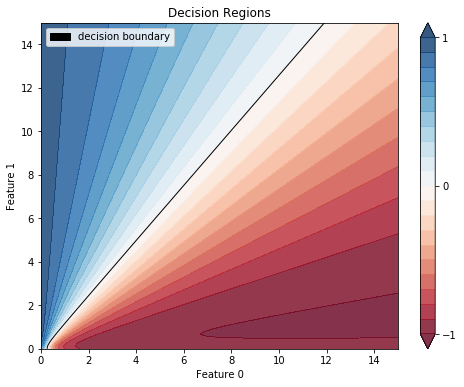

In [24]:
import matplotlib.patches as mpatches

# plot decision regions
cnt = plt.contourf(xx, yy, Z, levels=np.arange(-1, 1.1, 0.1), cmap=cm, alpha=0.8, extend="both")
a = plt.contour(xx, yy, Z, levels=[0.0], colors=("black",), linestyles=("-",), linewidths=(1,))
plt.colorbar(cnt, ticks=[-1, 0, 1])


plt.ylabel('Feature 1')
plt.xlabel('Feature 0')
plt.title("Decision Regions")

patch = mpatches.Patch(color='black', linestyle='-', label='decision boundary')
plt.legend(handles=[patch], loc='upper left')

plt.show()

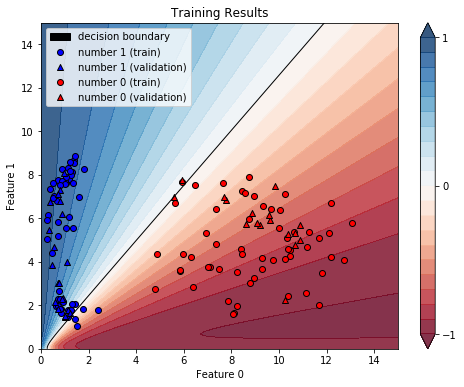

In [25]:
dim1 = 0
dim2 = 1

# plot decision regions
cnt = plt.contourf(xx, yy, Z, levels=np.arange(-1, 1.1, 0.1), cmap=cm, alpha=0.8, extend="both")
plt.contour(xx, yy, Z, levels=[0.0], colors=("black",), linestyles=("-",), linewidths=(1,))
plt.colorbar(cnt, ticks=[-1, 0, 1])

patch = mpatches.Patch(color='black', linestyle='-', label='decision boundary')

# plot data
a = plt.scatter(
    X_train[:, dim1][Y_train == 1],
    X_train[:, dim2][Y_train == 1],
    c="b",
    marker="o",
    edgecolors="k",
    label="number 1 (train)",
)
b = plt.scatter(
    X_val[:, dim1][Y_val == 1],
    X_val[:, dim2][Y_val == 1],
    c="b",
    marker="^",
    edgecolors="k",
    label="number 1 (validation)",
)
c = plt.scatter(
    X_train[:, dim1][Y_train == -1],
    X_train[:, dim2][Y_train == -1],
    c="r",
    marker="o",
    edgecolors="k",
    label="number 0 (train)",
)
d = plt.scatter(
    X_val[:, dim1][Y_val == -1],
    X_val[:, dim2][Y_val == -1],
    c="r",
    marker="^",
    edgecolors="k",
    label="number 0 (validation)",
)

plt.ylabel('Feature ' + str(dim2))
plt.xlabel('Feature ' + str(dim1))
plt.title("Training Results")

plt.legend(handles=[patch, a, b, c, d], loc='upper left')
plt.show()

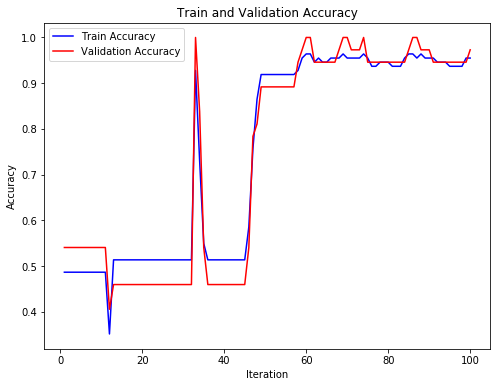

In [26]:
# plot acc train, acc val

plt.plot(iter_history, train_history, color='blue', label='Train Accuracy')
plt.plot(iter_history, val_history, color='red', label='Validation Accuracy')

plt.ylabel('Accuracy')
plt.xlabel('Iteration')
plt.title("Train and Validation Accuracy")

plt.legend()
plt.show()

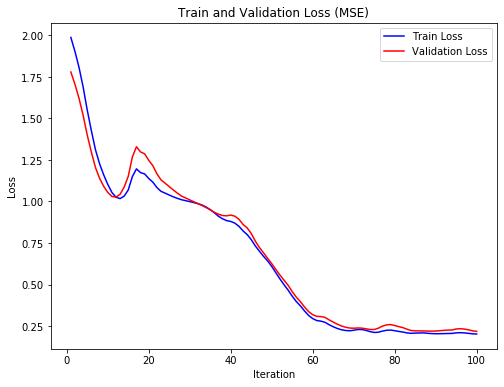

In [27]:
# plot loss train, loss val

plt.plot(iter_history, train_loss_history, color='blue', label='Train Loss')
plt.plot(iter_history, val_loss_history, color='red', label='Validation Loss')

plt.ylabel('Loss')
plt.xlabel('Iteration')
plt.title("Train and Validation Loss (MSE)")

plt.legend()
plt.show()

In [28]:
# confusion matrix plotter
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    #ax.set_ylim(ax.data.c - .5, - .5)
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    
    return ax


np.set_printoptions(precision=2)

In [29]:
y_pred_train = np.asarray(predictions_train)
y_pred_train = (y_pred_train+1)/2
y_pred_train = y_pred_train.astype(int)

y_pred_train

array([0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1,
       1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1,
       1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1,
       0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1,
       1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1,
       0])

In [30]:
y_train = (Y_train+1)/2
y_train = y_train.astype(int)

y_train

array([0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1,
       1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1,
       1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1,
       1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1,
       1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1,
       0])

In [31]:
y_pred_val = np.asarray(predictions_val)
y_pred_val = (y_pred_val+1)/2
y_pred_val = y_pred_val.astype(int)

y_pred_val

array([0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0,
       1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0])

In [32]:
y_val = (Y_val+1)/2
y_val = y_val.astype(int)

y_val

array([0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0,
       1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0])

In [33]:
# true label, number 0 and number 1
label = np.array(['number 0', 'number 1'])
label

array(['number 0', 'number 1'], dtype='<U8')

Confusion matrix, without normalization
[[56  1]
 [ 4 50]]
Normalized confusion matrix
[[0.98 0.02]
 [0.07 0.93]]


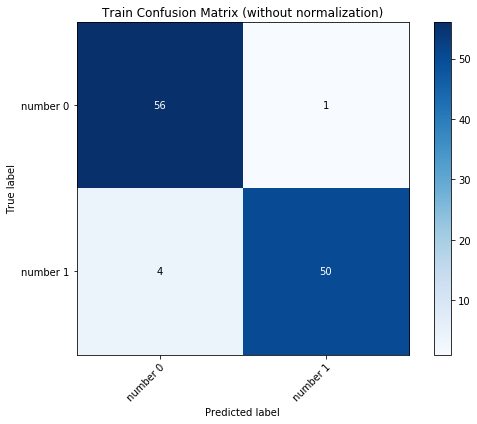

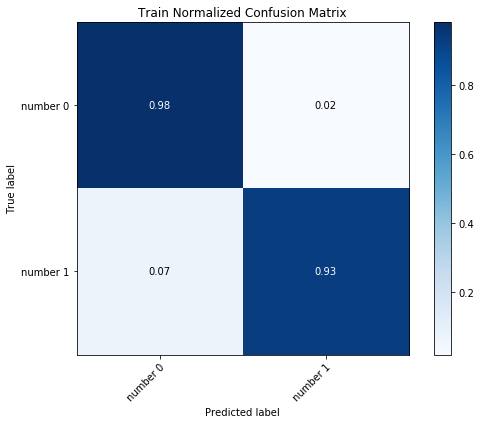

In [34]:
# confusion matrix for training

plot_confusion_matrix(y_train, y_pred_train, classes=label,
                      title='Train Confusion Matrix (without normalization)')

plot_confusion_matrix(y_train, y_pred_train, classes=label, normalize=True,
                      title='Train Normalized Confusion Matrix')

Confusion matrix, without normalization
[[16  1]
 [ 0 20]]
Normalized confusion matrix
[[0.94 0.06]
 [0.   1.  ]]


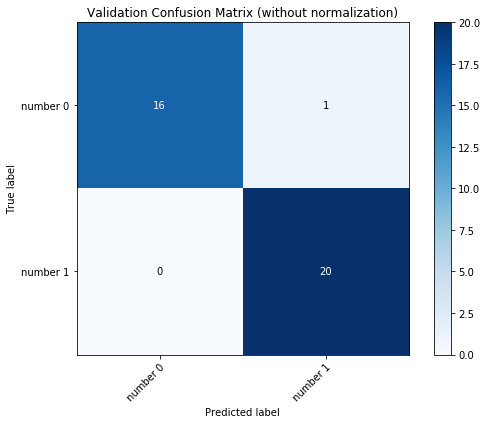

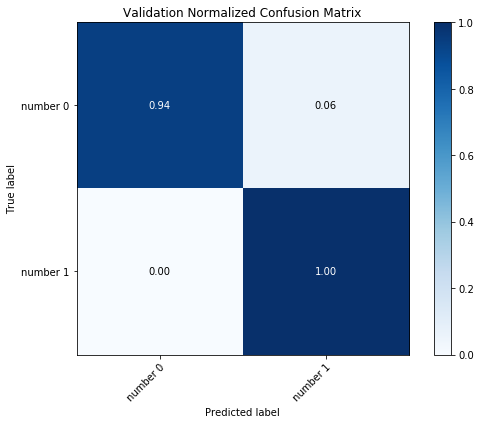

In [35]:
# confusion matrix for validation

plot_confusion_matrix(y_val, y_pred_val, classes=label,
                      title='Validation Confusion Matrix (without normalization)')

plot_confusion_matrix(y_val, y_pred_val, classes=label, normalize=True,
                      title='Validation Normalized Confusion Matrix')

In [36]:
# the weights and bias after training
var

[array([[[-6.73e-03, -3.91e-01, -6.76e-03],
         [ 1.49e-02,  5.72e-01,  9.54e-03]],
 
        [[ 2.25e-03, -4.83e-01,  4.33e-04],
         [-4.84e-03,  3.42e-01, -7.49e-03]],
 
        [[ 1.38e-02, -5.06e-01, -1.08e-02],
         [-1.01e-02,  3.56e-01,  6.22e-03]],
 
        [[ 1.68e-03, -5.50e-01, -1.04e-02],
         [-1.55e-02,  1.56e-01,  2.19e-02]],
 
        [[ 1.30e-02, -5.41e-01, -6.97e-03],
         [-1.26e-02,  1.67e-01,  5.89e-03]],
 
        [[ 8.48e-03, -6.03e-01, -1.08e-02],
         [-6.93e-03, -2.34e-02,  1.66e-02]]]), -0.026098117958761755]

In [37]:
# convert to array and save to csv file

weights = np.asarray(var[0]).reshape(num_qubits*num_layers,3)
bias = np.array([var[1]])

from numpy import savetxt

savetxt('C:/Users/user/Jupyter Notebook Project/Tugas Akhir/weights_QVC_mnist01_pca2.csv', weights, delimiter=',')
savetxt('C:/Users/user/Jupyter Notebook Project/Tugas Akhir/bias_QVC_mnist01_pca2.csv', bias, delimiter=',')

In [38]:
# load the weights and bias from csv file

a = loadtxt('C:/Users/user/Jupyter Notebook Project/Tugas Akhir/weights_QVC_mnist01_pca2.csv', delimiter=',')
b = loadtxt('C:/Users/user/Jupyter Notebook Project/Tugas Akhir/bias_QVC_mnist01_pca2.csv', delimiter=',')
a = np.reshape(a, (6,2,3))
b = np.reshape(b, (1,))

test = [a, b[0]]
test

[array([[[-6.73e-03, -3.91e-01, -6.76e-03],
         [ 1.49e-02,  5.72e-01,  9.54e-03]],
 
        [[ 2.25e-03, -4.83e-01,  4.33e-04],
         [-4.84e-03,  3.42e-01, -7.49e-03]],
 
        [[ 1.38e-02, -5.06e-01, -1.08e-02],
         [-1.01e-02,  3.56e-01,  6.22e-03]],
 
        [[ 1.68e-03, -5.50e-01, -1.04e-02],
         [-1.55e-02,  1.56e-01,  2.19e-02]],
 
        [[ 1.30e-02, -5.41e-01, -6.97e-03],
         [-1.26e-02,  1.67e-01,  5.89e-03]],
 
        [[ 8.48e-03, -6.03e-01, -1.08e-02],
         [-6.93e-03, -2.34e-02,  1.66e-02]]]), -0.026098117958761755]

In [39]:
test[0] == var[0]

array([[[ True,  True,  True],
        [ True,  True,  True]],

       [[ True,  True,  True],
        [ True,  True,  True]],

       [[ True,  True,  True],
        [ True,  True,  True]],

       [[ True,  True,  True],
        [ True,  True,  True]],

       [[ True,  True,  True],
        [ True,  True,  True]],

       [[ True,  True,  True],
        [ True,  True,  True]]])

In [40]:
test[1] == var[1]

True